# Exercise 1 

# Question 1 

In [31]:
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf  

In [33]:
RX = pd.read_excel("../data/Factors_Net.xlsx", sheet_name='All')
RX["date"] = pd.to_datetime(RX["date"], format="%Y%m%d")
RX = RX.set_index("date")
RX = RX.iloc[1:]
RX.head()

,DOL,CDOL,CAR,VAL,M1M,M3M,M6M,M1Y,VOL,SKEW,KURT
date,,,,,,,,,,,
1976-02-27,-0.006629,-0.006629,-0.058770,0.003982,0.040807,0.014140,0.014140,0.007180,0.003880,-0.003946,0.003817
1976-03-31,-0.011215,-0.011215,-0.042299,-0.074420,0.029744,0.030005,0.030005,0.030005,-0.067788,-0.040506,-0.051597
1976-04-30,-0.002435,-0.002435,-0.023935,-0.046766,0.030610,0.038017,0.038017,0.038017,-0.028100,-0.024332,-0.028213
1976-05-28,-0.007553,-0.007553,0.030442,0.027891,-0.023556,-0.021808,-0.021735,-0.021735,0.042642,0.057087,0.056599
1976-06-30,0.002889,0.002889,0.009257,0.018576,-0.006100,-0.017402,-0.012873,-0.012873,0.003532,0.004137,-0.001002


In [ ]:
window = 36
sigma = 0.1
sigma_monthly = sigma / np.sqrt(12)

## 1N

In [ ]:
#Raw weights
N = RX.shape[1]
weights = np.ones(N) / N

X_past = RX.iloc[:window].to_numpy()
Sigma = LedoitWolf().fit(X_past).covariance_

In [ ]:
# portfolio monthly variance from raw weights:
port_var = float(weights.T @ Sigma @ weights)
port_vol = np.sqrt(port_var)

# rescaling factor:
scale = sigma_monthly / port_vol

# final weights w_t:
w = scale * weights

In [ ]:
next_month_returns = RX.iloc[window].to_numpy()
RX_star = float(w @ next_month_returns)
RX_star

-0.005090493467259512

In [ ]:
def combined_1N_appendixE(RX, init_window=36, sigma_star_annual=0.10):
    sigma_star_monthly = sigma_star_annual / np.sqrt(12)

    T, N = RX.shape
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        # 1) expanding window up to t-1
        X_past = RX.iloc[:t].to_numpy()

        # 2) raw weights omega = 1/N
        omega = np.ones(N) / N

        # 3) Ledoit-Wolf Sigma_t
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())
    
    print(omega)
    print(w)
    return pd.Series(combined, index=RX.index, name="Combined_1N")

R_comb_1N = combined_1N_appendixE(RX)
R_comb_1N.dropna().tail()

[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
[0.23037475 0.23037475 0.23037475 0.23037475 0.23037475 0.23037475
 0.23037475 0.23037475 0.23037475 0.23037475 0.23037475]


date
2025-09-30    0.013528
2025-10-31    0.023730
2025-11-28    0.014692
2025-12-31    0.022766
2026-01-30    0.019672
Name: Combined_1N, dtype: float64

## MEAN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MEAN(RX, init_window=36, sigma_star_annual=0.10):
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        # 1) use past data only (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # 2) expected returns (historical mean)
        mu = np.nanmean(X_past, axis=0)

        # 3) MEAN raw weights omega
        denom = float(np.sum(mu))
        if np.abs(denom) > 1e-12:
            omega = mu / denom
        else:
            omega = np.ones(N) / N  # fallback if sum(mu)=0

        # 4) Ledoit–Wolf covariance for scaling (drop rows with NaNs)
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]
        if X_cov.shape[0] < 5:
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        # 5) scale ex-ante to 10% annual volatility
        port_var = float(omega.T @ Sigma @ omega)
        if port_var > 0 and np.isfinite(port_var):
            w = (sigma_star_monthly / np.sqrt(port_var)) * omega
        else:
            w = np.ones(N) / N

        # 6) realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="Mean")

In [ ]:
R_MEAN = combined_MEAN(RX)
R_MEAN.dropna().head()

date
1979-02-28    0.010664
1979-03-30    0.045602
1979-04-30    0.047283
1979-05-31   -0.008655
1979-06-29    0.025583
Name: Mean, dtype: float64

## VOL

In [ ]:
# 1) Raw weight rules (omega_t)
# ----------------------------
def raw_weights(mu: np.ndarray, sd: np.ndarray, method: str) -> np.ndarray:
    """
    Returns raw weights omega_t for Appendix E methods (except MINVAR/MAXRET).
    mu, sd computed using data up to t-1 (expanding window).
    """
    method = method.upper()
    N = len(mu)

    if method == "1N":
        return np.ones(N) / N

    if method == "MEAN":
        denom = np.sum(mu)
        return (mu / denom) if np.abs(denom) > 1e-12 else np.ones(N) / N

    if method == "VOL":
        inv_sd = np.where(sd > 0, 1.0 / sd, 0.0)
        denom = np.sum(inv_sd)
        return (inv_sd / denom) if denom > 0 else np.ones(N) / N

    if method == "SR":
        SR = np.where(sd > 0, mu / sd, 0.0)
        denom = np.sum(SR)
        return (SR / denom) if np.abs(denom) > 1e-12 else np.ones(N) / N

    if method == "TOP3":
        SR = np.where(sd > 0, mu / sd, -np.inf)
        top_idx = np.argsort(SR)[::-1][:min(3, N)]
        omega = np.zeros(N)
        denom = np.sum(SR[top_idx])
        if np.isfinite(denom) and np.abs(denom) > 1e-12:
            omega[top_idx] = SR[top_idx] / denom
        else:
            omega[top_idx] = 1.0 / len(top_idx)
        return omega

    raise ValueError(f"Unknown method for raw_weights: {method}")

In [ ]:
def combined_VOL(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        sd = X_past.std(axis=0, ddof=1)

        # 2) raw VOL weights omega
        inv_sd = 1 / sd
        omega = inv_sd / inv_sd.sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [ ]:
R_vol = combined_VOL(RX)
R_vol.dropna().head()

date
1979-02-28   -0.004186
1979-03-30    0.007913
1979-04-30    0.039772
1979-05-31   -0.009601
1979-06-29    0.020704
Name: Combined_VOL, dtype: float64

## SR Method

In [ ]:
def combined_SR(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        mu = X_past.mean(axis=0)
        sd = X_past.std(axis=0, ddof=1)

        # 2) raw SR weights omega
        SR = mu/sd
        omega = SR / SR.sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [ ]:
R_SR = combined_SR(RX)
R_SR.dropna().head()

date
1979-02-28    0.010297
1979-03-30    0.050926
1979-04-30    0.050936
1979-05-31   -0.008380
1979-06-29    0.022284
Name: Combined_VOL, dtype: float64

## Top 3 Method

In [ ]:
def combined_top3(RX, init_window=36):
    RX = RX.dropna(how="all")  # remove all-NaN rows
    T, N = RX.shape

    sigma_star_monthly = 0.10 / np.sqrt(12)
    combined = np.full(T, np.nan)

    for t in range(init_window, T):
        X_past = RX.iloc[:t].to_numpy()

        # 1) volatility per strategy
        mu = X_past.mean(axis=0)
        sd = X_past.std(axis=0, ddof=1)
        SR = mu/sd

        # 2) raw top3 weights omega
        
        top_idx = np.argsort(SR)[::-1][:3]
        omega = np.zeros_like(SR)
        omega[top_idx] = SR[top_idx] / SR[top_idx].sum()

        # 3) Ledoit–Wolf covariance
        Sigma = LedoitWolf().fit(X_past).covariance_

        # 4) rescale to target vol
        port_vol = np.sqrt(float(omega.T @ Sigma @ omega))
        w = (sigma_star_monthly / port_vol) * omega

        # 5) combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Combined_VOL")

In [ ]:
R_Top3 = combined_top3(RX)
R_Top3.dropna().head()

date
1979-02-28    0.003855
1979-03-30    0.032322
1979-04-30    0.076993
1979-05-31   -0.017925
1979-06-29    0.007048
Name: Combined_VOL, dtype: float64

## MaxRet

In [ ]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MaxRet(RX, init_window=36, sigma_star_annual=0.10):
    """
    MaxRet: maximize w' mu subject to:
      (1) 1' w = 1
      (2) w' Sigma w = (sigma_star_monthly)^2
    Expanding window, monthly rebalancing, Sigma estimated by LedoitWolf.
    """
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    target_var = float(sigma_star_monthly**2)

    combined = np.full(T, np.nan)
    ones = np.ones(N)

    for t in range(init_window, T):
        # Past data (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # Mean vector mu (historical mean, expanding window)
        mu = np.nanmean(X_past, axis=0)

        # Ledoit–Wolf covariance needs complete rows
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]
        if X_cov.shape[0] < 5:
            # fallback if too few clean rows
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        Sinv = np.linalg.pinv(Sigma)

        # Scalars
        A = float(ones @ Sinv @ ones)
        B = float(ones @ Sinv @ mu)
        C = float(mu   @ Sinv @ mu)
        c = target_var

        # Solve for gamma using the variance constraint -> quadratic
        # Derived from the constrained MV solution with 1'w=1 and w'Σw=c
        a2 = A * (1.0 - c * A)
        b2 = -2.0 * B * (1.0 - c * A)
        c2 = C - c * (B**2)

        disc = b2*b2 - 4.0*a2*c2

        def make_feasible(w):
            """Enforce sum-to-1 and hit variance target (numerical safety)."""
            s = np.sum(w)
            if np.abs(s) > 1e-12:
                w = w / s
            var = float(w @ Sigma @ w)
            if var > 0 and np.isfinite(var):
                w = (sigma_star_monthly / np.sqrt(var)) * w
                # re-enforce sum-to-1 after scaling (tiny drift)
                s2 = np.sum(w)
                if np.abs(s2) > 1e-12:
                    w = w / s2
            return w

        if disc < 0 or np.abs(a2) < 1e-14:
            # fallback: use MinVar direction then scale
            w = (Sinv @ ones) / float(ones @ Sinv @ ones)
            w = make_feasible(w)
        else:
            g1 = (-b2 + np.sqrt(disc)) / (2.0 * a2)
            g2 = (-b2 - np.sqrt(disc)) / (2.0 * a2)

            def w_from_g(g):
                lam = (B - g * A)
                if np.abs(lam) < 1e-14:
                    return np.ones(N) / N
                w = (1.0 / lam) * (Sinv @ (mu - g * ones))
                return w

            w1 = make_feasible(w_from_g(g1))
            w2 = make_feasible(w_from_g(g2))

            # Choose the one with higher expected return
            w = w1 if float(w1 @ mu) >= float(w2 @ mu) else w2

        # Realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="MaxRet")

In [ ]:
R_MaxRet = combined_MaxRet(RX)
R_MaxRet.dropna().head()

date
1979-02-28    0.014432
1979-03-30    0.069423
1979-04-30    0.066929
1979-05-31   -0.009461
1979-06-29    0.018048
Name: MaxRet, dtype: float64

## MinVar

In [ ]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def combined_MinVar(RX, init_window=36, sigma_star_annual=0.10):
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12.0)
    combined = np.full(T, np.nan)

    ones = np.ones(N)

    for t in range(init_window, T):
        # 1) use past data only (up to t-1)
        X_past = RX.iloc[:t].to_numpy(dtype=float)

        # 2) Ledoit–Wolf covariance (drop rows with NaNs)
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]

        if X_cov.shape[0] < 5:
            # fallback if too few complete observations
            Sigma = np.cov(np.nan_to_num(X_past), rowvar=False)
        else:
            Sigma = LedoitWolf().fit(X_cov).covariance_

        # 3) MinVar raw weights omega_t = Σ^{-1}1 / (1'Σ^{-1}1)
        Sinv = np.linalg.pinv(Sigma)
        denom = float(ones @ Sinv @ ones)
        omega = (Sinv @ ones) / denom if np.abs(denom) > 1e-12 else np.ones(N) / N

        # 4) Scale ex-ante to 10% annual volatility
        port_var = float(omega.T @ Sigma @ omega)
        if port_var > 0 and np.isfinite(port_var):
            w = (sigma_star_monthly / np.sqrt(port_var)) * omega
        else:
            w = np.ones(N) / N

        # 5) Realized combined return at time t
        combined[t] = float(w @ RX.iloc[t].to_numpy(dtype=float))

    return pd.Series(combined, index=RX.index, name="MinVar")

In [ ]:
R_MinVar = combined_MinVar(RX)
R_MinVar.dropna().head()

date
1979-02-28   -0.007272
1979-03-30    0.001687
1979-04-30    0.038695
1979-05-31   -0.010451
1979-06-29    0.007464
Name: MinVar, dtype: float64

## Combined results

In [ ]:
R_comb_1N.name = "Naive"
R_vol.name = "Volatility"
R_SR.name = "Sharpe Ratio"
R_Top3.name = "Top-3"
R_MEAN.name = "Mean"
R_MinVar.name = "Min Variance"
R_MaxRet.name = "Max Return"

all_results = pd.concat(
    [R_comb_1N, R_MEAN, R_vol, R_SR, R_Top3, R_MaxRet, R_MinVar],
    axis=1
)

all_results = all_results.dropna()
all_results.head()

,Naive,Mean,Volatility,Sharpe Ratio,Top-3,Max Return,Min Variance
date,,,,,,,
1979-02-28,-0.005090,0.010664,-0.004186,0.010297,0.003855,0.014432,-0.007272
1979-03-30,0.020498,0.045602,0.007913,0.050926,0.032322,0.069423,0.001687
1979-04-30,0.050749,0.047283,0.039772,0.050936,0.076993,0.066929,0.038695
1979-05-31,-0.010332,-0.008655,-0.009601,-0.008380,-0.017925,-0.009461,-0.010451
1979-06-29,0.019705,0.025583,0.020704,0.022284,0.007048,0.018048,0.007464


In [ ]:
import numpy as np
import pandas as pd

def summary_stats(r):
    
    mean_monthly = r.mean()
    vol_monthly = r.std()
    
    mean_ann = mean_monthly * 12
    vol_ann = vol_monthly * np.sqrt(12)
    
    sharpe = mean_ann / vol_ann
    
    downside = r[r < 0]
    sortino = mean_ann / (downside.std() * np.sqrt(12))
    
    return pd.Series({
        "Annualized Mean": mean_ann,
        "Annualized Volatility": vol_ann,
        "Sharpe Ration": sharpe,
        "Sortino Ratio": sortino
    })

In [ ]:
all_results.apply(summary_stats).T


,Annualized Mean,Annualized Volatility,Sharpe Ration,Sortino Ratio
Naive,0.061295,0.106389,0.576137,0.757016
Mean,0.047334,0.093082,0.508516,0.660863
Volatility,0.061370,0.107207,0.572449,0.763741
Sharpe Ratio,0.048346,0.094264,0.512883,0.668065
Top-3,0.053163,0.100335,0.529852,0.691013
Max Return,0.051873,0.092467,0.560995,0.756150
Min Variance,0.053826,0.108372,0.496677,0.719616


## Combined Returns

In [ ]:
import matplotlib.pyplot as plt

cum_returns = (1 + all_results).cumprod()

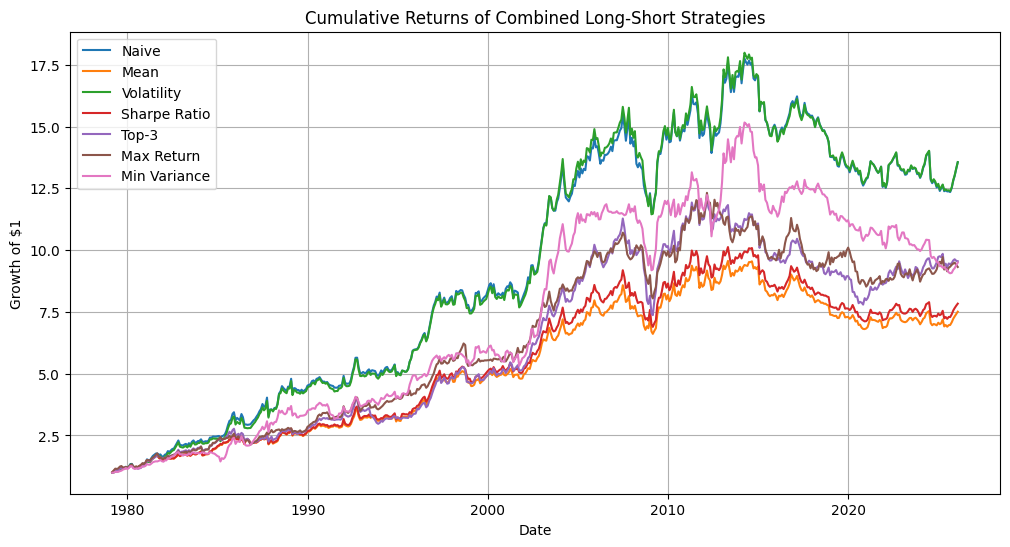

In [ ]:
plt.figure(figsize=(12,6))

for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.title("Cumulative Returns of Combined Long-Short Strategies")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

# Question 2
Other way could be the exponentially-weighted sharpe combination. Instead of just using the simple hsitorical mean and sd we compute exponentially weighted mean and volatility so that recent performance matters more. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize


def _downside_erc_objective(w: np.ndarray, cov_matrix: np.ndarray) -> float:
    """
    Fonction objectif : minimiser la variance des contributions au risque baissier.
    """
    port_var = w.T @ cov_matrix @ w
    if port_var <= 0:
        return 1e9

    port_vol = np.sqrt(port_var)
    # Contribution Marginale au Risque (MRC)
    mrc = (cov_matrix @ w) / port_vol
    # Contribution au Risque (RC)
    rc = w * mrc

    # Cible : chaque actif contribue de manière égale au risque
    target_rc = port_vol / len(w)

    # On minimise la somme des carrés des écarts par rapport à la cible
    return np.sum((rc - target_rc)**2)


def combined_downside_parity(
    RX: pd.DataFrame,
    init_window: int = 36,
    sigma_star_annual: float = 0.10,
    mar: float = 0.0  # Minimum Acceptable Return (0.0 par défaut)
) -> pd.Series:
    """
    Combinaison ex-ante : Downside Risk Parity -> vol target (10% p.a.)
    Utilise la semi-covariance de LedoitWolf pour dériver les poids ERC,
    et la covariance totale pour la mise à l'échelle finale.
    """
    RX = RX.dropna(how="all").copy()
    T, N = RX.shape

    sigma_star_monthly = sigma_star_annual / np.sqrt(12)
    combined = np.full(T, np.nan)

    # Contraintes et bornes pour l'optimisation (long-only, la somme des poids = 1)
    bounds = tuple((0.0, 1.0) for _ in range(N))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    init_guess = np.ones(N) / N

    for t in range(init_window, T):
        X_past_df = RX.iloc[:t]
        X_past = X_past_df.to_numpy()

        # Nettoyage des NaNs pour LedoitWolf
        mask = np.isfinite(X_past).all(axis=1)
        X_cov = X_past[mask, :]

        if len(X_cov) == 0:
            combined[t] = 0.0
            continue

        # 1) Calcul des rendements baissiers (Downside returns)
        # On ne garde que les rendements inférieurs au seuil (MAR)
        X_down = np.minimum(X_cov - mar, 0.0)

        # 2) Matrice de semi-covariance via Ledoit-Wolf
        Sigma_down = LedoitWolf().fit(X_down).covariance_

        # 3) Optimisation pour trouver les poids Downside Parity (Equal Risk Contribution)
        res = minimize(
            _downside_erc_objective,
            init_guess,
            args=(Sigma_down,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            tol=1e-8
        )

        # Poids optimaux (ou équipondération si échec de convergence)
        omega = res.x if res.success else init_guess

        # 4) Ex-ante vol scaling à 10% p.a. (mensuel)
        # Remarque : on utilise la covariance *totale* pour le target vol global,
        # même si les poids sont basés sur le risque baissier.
        Sigma_total = LedoitWolf().fit(X_cov).covariance_
        port_vol = np.sqrt(float(omega.T @ Sigma_total @ omega))

        w = (sigma_star_monthly / port_vol) * \
            omega if port_vol > 0 else init_guess

        # 5) Rendement combiné réalisé au temps t
        combined[t] = float(w @ RX.iloc[t].to_numpy())

    return pd.Series(combined, index=RX.index, name="Downside_Parity")

In [ ]:
R_EW_SR = combined_downside_parity(RX)
R_EW_SR.name = "Downside_Parity"

all_results_q2 = pd.concat([all_results, R_EW_SR], axis=1).dropna()
all_results_q2.head()

,Naive,Mean,Volatility,Sharpe Ratio,Top-3,Max Return,Min Variance,Downside_Parity
date,,,,,,,,
1979-02-28,-0.005090,0.010664,-0.004186,0.010297,0.003855,0.014432,-0.007272,-0.005090
1979-03-30,0.020498,0.045602,0.007913,0.050926,0.032322,0.069423,0.001687,0.020498
1979-04-30,0.050749,0.047283,0.039772,0.050936,0.076993,0.066929,0.038695,0.050749
1979-05-31,-0.010332,-0.008655,-0.009601,-0.008380,-0.017925,-0.009461,-0.010451,-0.010332
1979-06-29,0.019705,0.025583,0.020704,0.022284,0.007048,0.018048,0.007464,0.019705


In [ ]:
all_results_q2.apply(summary_stats).T.sort_values('Annualized Mean')

,Annualized Mean,Annualized Volatility,Sharpe Ration,Sortino Ratio
Mean,0.047334,0.093082,0.508516,0.660863
Sharpe Ratio,0.048346,0.094264,0.512883,0.668065
Max Return,0.051873,0.092467,0.560995,0.756150
Top-3,0.053163,0.100335,0.529852,0.691013
Min Variance,0.053826,0.108372,0.496677,0.719616
Naive,0.061295,0.106389,0.576137,0.757016
Downside_Parity,0.061295,0.106389,0.576137,0.757016
Volatility,0.061370,0.107207,0.572449,0.763741


In [ ]:
import matplotlib.pyplot as plt

cum_returns = (1 + all_results_q2).cumprod()

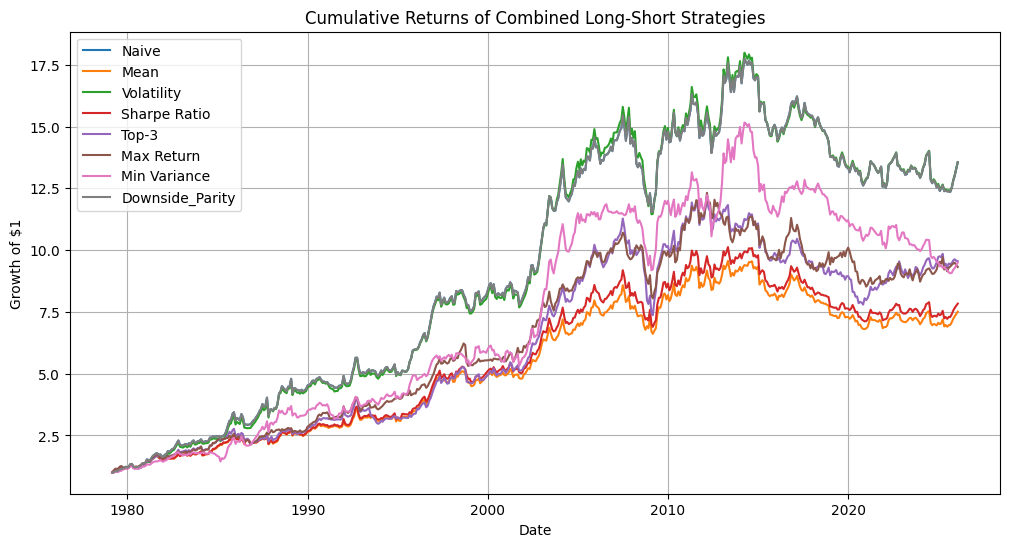

In [ ]:
plt.figure(figsize=(12,6))

for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.title("Cumulative Returns of Combined Long-Short Strategies")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()